In [1]:
import import_ipynb

import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
# from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import pygame
from environment import TicTacToe3D
from qAgent import QAgent
from dumbAgent import DumbAgent

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pygame 2.5.2 (SDL 2.28.2, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html
importing Jupyter notebook from environment.ipynb
importing Jupyter notebook from qAgent.ipynb
importing Jupyter notebook from dumbAgent.ipynb


In [2]:
episode_scores1 = []
episode_scores2 = []
moves = []

def plot_moves(show_result=False):
    plt.figure(1)
    moves_t = torch.tensor(moves, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Moves')
    
    plt.plot(moves, color='red', alpha=0.2)

    if len(moves_t) >= 100:
        means = moves_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_scores(show_result=False):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Final Score')

    plt.plot(episode_scores1, label='My bot play first')
    plt.legend(loc="upper left")

    plt.show()

    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Final Score')

    plt.plot(episode_scores2, label='My bot play second')
    plt.legend(loc="upper left")
    # plt.legend(loc="upper left")

    # plt.pause(0.001)  # pause a bit so that plots are updated
    # if is_ipython:
    #     if not show_result:
    #         display.display(plt.gcf())
    #         display.clear_output(wait=True)
    #     else:
    #         display.display(plt.gcf())

In [3]:
env = TicTacToe3D(headless=False)
qAgent = QAgent(training=True)
# qAgent.load_weights("./weights/qlearn.pth")
dumpAgent = DumbAgent(depth=2)

In [4]:
def finalScore(t, result, player, is_first_player=True):
    if result == 0:
        return 0
    elif result == player:
        if is_first_player:
            return (71 - t) / 64
        else:
            return (72 - t) / 64
    else:
        if is_first_player:
            return ((t - 8) / 56) - 1
        else:
            return ((t - 7) / 56) - 1

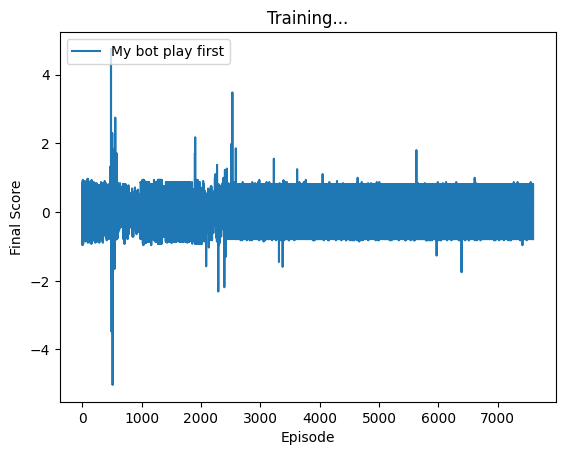

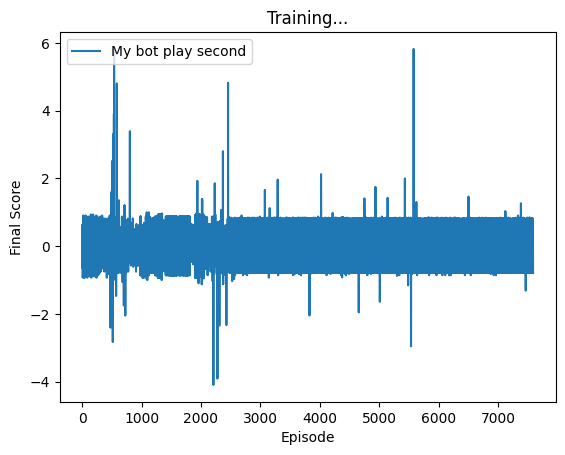

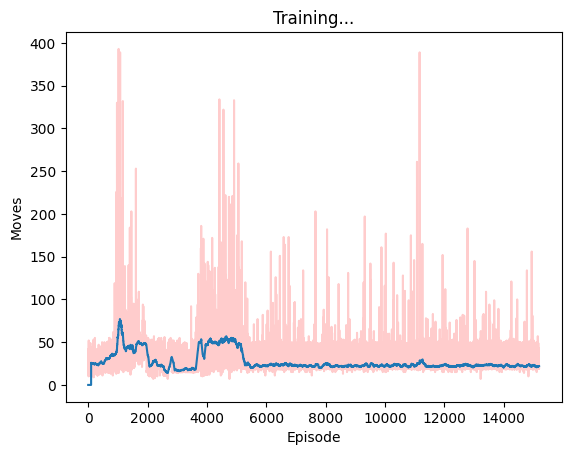

<Figure size 640x480 with 0 Axes>

In [5]:
num_episodes = 50000

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, possible_move = env.reset()
    env.draw_lines()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).view(-1, 64)

    # print(state)

    first_player = 1 if i_episode % 2 == 0 else -1
    player = first_player

    if i_episode % 1000 == 0:
        qAgent.save_weights(f"./weights/qlearn-{i_episode}.pth")

    t = 0
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()

        if player == 1:
            action = qAgent.findBestMove(board=state * player, possible_move=possible_move, player=player)
        else:
            action = qAgent.findBestMove(board=state * player, possible_move=possible_move, player=player)

            # action = dumpAgent.findBestMove(board=state.view(4,4,4).cpu().detach().numpy(), possible_move=possible_move, player=player)
            # if action != None:
            #     action = torch.tensor([4 * action[0] + action[1]], device=device).unsqueeze(0)

        # print(f"{player} {action}")

        if action == None:
            # terminated = draw
            movable = False
            reward = 0
            terminated = True
        else:
            act = action.item()

            # print(act)
            row = act // 4
            col = act % 4
            # print(f"{player} {row+1}, {col+1}")
            # terminated = lose
            movable, observation, possible_move, reward, terminated = env.move(row, col, player)

            env.draw_figures()

        reward = torch.tensor([reward], device=device)
        done = terminated or (action == None)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).view(-1, 64)

        # Store the transition in memory
        # action_remember = torch.zeros(16, dtype=torch.int64, device=device)
        # action_remember[action.item()] = 1
        if action != None:
            if next_state == None:
                qAgent.memory.push(state * player, action, None, reward)
            else:
                qAgent.memory.push(state * player, action, next_state * player, reward)

        # Move to the next state
        state = next_state
        if movable:
            player = -player
            t += 1

        # Perform one step of the optimization (on the policy network)
        qAgent.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = qAgent.target_net.state_dict()
        policy_net_state_dict = qAgent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*qAgent.TAU + target_net_state_dict[key]*(1-qAgent.TAU)
        qAgent.target_net.load_state_dict(target_net_state_dict)

        if done:
            if first_player == 1:
                episode_scores1.append(finalScore(t, env.check(), 1, is_first_player=True))
            else:
                episode_scores2.append(finalScore(t, env.check(), 1, is_first_player=False))
            moves.append(t)
            # episode_durations.append(finalScore(t, reward.item(), player))
            plot_scores()
            plt.show()
            plot_moves()
            break

qAgent.save_weights("./weights/qlearn.pth")

print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()
plot_moves(show_result=True)
plt.ioff()
plt.show()

In [ ]:
# qAgent.save_weights("./weights/qlearn.pth")
pygame.quit()